In [197]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import rasterio.mask
import matplotlib.image as mpimg

from pykrige.ok import OrdinaryKriging
from rasterio.plot import show
from rasterio.transform import Affine
from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import box
from shapely.geometry import Polygon, Point
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from pyidw import idw
from osgeo import gdal

# Load Discrete Data and Continuous Data

In [2]:
dfDis = pd.read_csv(r"D:\Water Quailty\OEAT_Discrete-2022-Aug-31.csv")
dfDis.head()

C:\Users\xiang11\AppData\Local\Temp\ipykernel_8096\2477443654.py:1: DtypeWarning: Columns (6,17,18,19,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  dfDis = pd.read_csv(r"D:\Water Quailty\OEAT_Discrete-2022-Aug-31.csv")


,RowID,ProgramID,ProgramName,DataFileName,ParameterName,ParameterUnits,ProgramLocationID,ActivityType,SampleDate,Year,...,ResultComments,Latitude_DD,Longitude_DD,ManagedAreaName,Region,SEACAR_QAQCFlagCode,SEACAR_QAQC_Description,Include,SEACAR_EventID,AreaID
0,1,118,"National Aquatic Resource Surveys, National Co...",Data_118E_Final.csv,Chlorophyll a uncorrected for pheophytin,ug/L,FL01-0015,Sample,2001-12-31,2001,...,NaN,26.56520,-82.06790,Matlacha Pass Aquatic Preserve,SW,6Q,6Q - Within threshold tolerance,1,3521AFD2-7CB5-472C-9F0A-094711354B17,28
1,2,118,"National Aquatic Resource Surveys, National Co...",Data_118E_Final.csv,Chlorophyll a uncorrected for pheophytin,ug/L,FLW05-0009,Sample,2005-12-31,2005,...,NaN,26.58742,-82.06785,Matlacha Pass Aquatic Preserve,SW,6Q,6Q - Within threshold tolerance,1,4F7FAE89-44E6-4527-B780-62604BEDA08E,28
2,3,118,"National Aquatic Resource Surveys, National Co...",Data_118E_Final.csv,Chlorophyll a uncorrected for pheophytin,ug/L,FLW06-0042,Sample,2006-12-31,2006,...,NaN,26.63835,-82.21297,Pine Island Sound Aquatic Preserve,SW,6Q,6Q - Within threshold tolerance,1,135985C4-315B-430F-B56A-BCBA0ECEE7B8,34
3,4,118,"National Aquatic Resource Surveys, National Co...",Data_118E_Final.csv,Chlorophyll a uncorrected for pheophytin,ug/L,FLW06-0041,Sample,2006-12-31,2006,...,NaN,26.83697,-82.09640,Gasparilla Sound-Charlotte Harbor Aquatic Pres...,SW,6Q,6Q - Within threshold tolerance,1,ED7F7EC6-3254-4768-9CCC-7744025DFE2F,18
4,5,118,"National Aquatic Resource Surveys, National Co...",Data_118E_Final.csv,Chlorophyll a uncorrected for pheophytin,ug/L,FL00-0020,Sample,2000-12-31,2000,...,NaN,26.75800,-82.08850,Gasparilla Sound-Charlotte Harbor Aquatic Pres...,SW,6Q,6Q - Within threshold tolerance,1,B3933D86-BB5A-4431-AC1C-3793B782E615,18


In [3]:
dfCon = pd.read_csv(r"D:\Water Quailty\OEAT_Continuous-2022-Nov-04.csv")
dfCon.head()

C:\Users\xiang11\AppData\Local\Temp\ipykernel_8096\4096462767.py:1: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  dfCon = pd.read_csv(r"D:\Water Quailty\OEAT_Continuous-2022-Nov-04.csv")


,RowID,ProgramID,ProgramName,DataFileName,ParameterName,ParameterUnits,ProgramLocationID,ActivityType,SampleDate,Year,...,ResultComments,Latitude_DD,Longitude_DD,ManagedAreaName,Region,SEACAR_QAQCFlagCode,SEACAR_QAQC_Description,Include,SEACAR_EventID,AreaID
0,54292147,354,Rookery Bay National Estuarine Research Reserv...,Data_354B_Final.csv,Turbidity,NTU,gtmfmwq,NaN,2010-01-01,2010,...,NaN,29.737041,-81.245953,Guana Tolomato Matanzas National Estuarine Res...,NE,6Q,6Q - Within threshold tolerance,1,4B51AEFD-B82B-4A1B-9495-387380534325,20
1,54292148,354,Rookery Bay National Estuarine Research Reserv...,Data_354B_Final.csv,Dissolved Oxygen Saturation,%,gtmfmwq,NaN,2010-01-01,2010,...,NaN,29.737041,-81.245953,Guana Tolomato Matanzas National Estuarine Res...,NE,6Q,6Q - Within threshold tolerance,1,EA3E3E10-AC00-4E27-9792-B34F398DB47A,20
2,54292149,354,Rookery Bay National Estuarine Research Reserv...,Data_354B_Final.csv,Dissolved Oxygen Saturation,%,gtmfmwq,NaN,2010-01-01,2010,...,NaN,29.737041,-81.245953,Guana Tolomato Matanzas National Estuarine Res...,NE,6Q,6Q - Within threshold tolerance,1,7DFDEF12-6F63-46DE-B406-69846C4E3C5B,20
3,54292150,354,Rookery Bay National Estuarine Research Reserv...,Data_354B_Final.csv,Dissolved Oxygen Saturation,%,gtmfmwq,NaN,2010-01-01,2010,...,NaN,29.737041,-81.245953,Guana Tolomato Matanzas National Estuarine Res...,NE,6Q,6Q - Within threshold tolerance,1,ADA898FC-65D2-467D-B741-5EBA8C0A4C8C,20
4,54292151,354,Rookery Bay National Estuarine Research Reserv...,Data_354B_Final.csv,Water Temperature,Degrees C,gtmfmwq,NaN,2010-01-01,2010,...,NaN,29.737041,-81.245953,Guana Tolomato Matanzas National Estuarine Res...,NE,6Q,6Q - Within threshold tolerance,1,65C5A73E-30FF-49B6-B872-18585547CF95,20


In [4]:
def load_data(filepath):
    df = pd.read_csv(filepath)
    
    #---------- Select managed areas, and columns -----------------
    # df2 = df.loc[df["ManagedAreaName"].isin(["Guana Tolomato Matanzas National Estuarine Research Reserve",
    #                             "Biscayne Bay Aquatic Preserve",
    #                             "Estero Bay Aquatic Preserve",
    #                             "Gasparilla Sound-Charlotte Harbor Aquatic Preserve",
    #                             "Big Bend Seagrasses Aquatic Preserve"])]
    df2 = df
    df2 = df2[['RowID','ParameterName','ParameterUnits','ProgramLocationID','ActivityType','ManagedAreaName',
               'SampleDate','Year','Month','ResultValue','ValueQualifier','Latitude_DD','Longitude_DD']]
    df2 = df2.loc[df2["ParameterName"].isin(["Salinity","Total Nitrogen","Dissolved Oxygen","Turbidity","Secchi Depth"])]
    df2["timestamp"]=  pd.to_datetime(df2['SampleDate'])

    #---------- remove outliers -----------------
    # Remove total nitrogen outliers (>100)
    df2.drop(df2[(df2['ParameterName'] == 'Total Nitrogen') & 
        (df2['ResultValue'] > 10)].index,inplace=True)
    
    # Remove a single measurement in 1996-07-22 (RowID: 1582917)
    df2.drop(df2[df2['RowID'] == 1582917].index, inplace=True)
    
    # Remove turbidity outliers (>25)
    df2.drop(df2[(df2['ParameterName'] == 'Turbidity') & 
        (df2['ResultValue'] > 25)].index, inplace=True)
    
    # Remove Secchi Depth before 1995 (117 records)
    df2.drop(df2[(df2['ParameterName'] == 'Secchi Depth') & 
        (df2['Year'] < 1995)].index, inplace=True)
    
    #---------- create list of parameters, areas, values and dictionaries -----------------
    listPara = ["Salinity","Total Nitrogen","Dissolved Oxygen","Turbidity","Secchi Depth"] 
    #listArea = ["Guana Tolomato Matanzas National Estuarine Research Reserve",
    #                             "Biscayne Bay Aquatic Preserve",
    #                             "Estero Bay Aquatic Preserve",
    #                             "Gasparilla Sound-Charlotte Harbor Aquatic Preserve",
    #                             "Big Bend Seagrasses Aquatic Preserve" ]
    listArea = df["ManagedAreaName"].unique()
    listValue = ["count", "mean","max","min","std"]
    dictUnits = {"Salinity":"ppt","Total Nitrogen": "mg/L","Dissolved Oxygen": "mg/L","Turbidity": "NTU", "Secchi Depth": "m"}
    dictMonth = {1:"January",2:"February",3:"March",4:"April",5:"May",6:"June",7:"July",8:"August",
                 9:"September",10:"October",11:"November",12:"December"}
    dictArea = {'Gasparilla Sound-Charlotte Harbor Aquatic Preserve':'Charlotte Harbor','Big Bend Seagrasses Aquatic Preserve':'Big Bend',
                'Guana Tolomato Matanzas National Estuarine Research Reserve':'GTM Reserve','Estero Bay Aquatic Preserve':'Estero Bay',
                'Biscayne Bay Aquatic Preserve':'Biscayne Bay','Matlacha Pass Aquatic Preserve':'Matlacha Pass AP',
                'Lemon Bay Aquatic Preserve':'Lemon Bay','Cape Haze Aquatic Preserve':'Cape Haze AP','Pine Island Sound Aquatic Preserve':'Pine Island'}
    
    return df2, listPara, listArea, listValue, dictUnits, dictMonth, dictArea

In [5]:
dfDis = dfDis[['RowID','ParameterName','ParameterUnits','ProgramLocationID','ActivityType','ManagedAreaName',
               'SampleDate','Year','Month','ResultValue','ValueQualifier','Latitude_DD','Longitude_DD']]
dfDis = dfDis.loc[dfDis["ParameterName"].isin(["Salinity","Total Nitrogen","Dissolved Oxygen","Turbidity","Secchi Depth"])]
dfDis["timestamp"]=  pd.to_datetime(dfDis['SampleDate'])
#---------- remove outliers -----------------
# Remove total nitrogen outliers (>100)
dfDis.drop(dfDis[(dfDis['ParameterName'] == 'Total Nitrogen') & 
    (dfDis['ResultValue'] > 10)].index,inplace=True)

# Remove a single measurement in 1996-07-22 (RowID: 1582917)
dfDis.drop(dfDis[dfDis['RowID'] == 1582917].index, inplace=True)

# Remove turbidity outliers (>25)
dfDis.drop(dfDis[(dfDis['ParameterName'] == 'Turbidity') & 
    (dfDis['ResultValue'] > 25)].index, inplace=True)

# Remove Secchi Depth before 1995 (117 records)
dfDis.drop(dfDis[(dfDis['ParameterName'] == 'Secchi Depth') & 
    (dfDis['Year'] < 1995)].index, inplace=True)
dfDis.head()

,RowID,ParameterName,ParameterUnits,ProgramLocationID,ActivityType,ManagedAreaName,SampleDate,Year,Month,ResultValue,ValueQualifier,Latitude_DD,Longitude_DD,timestamp
19,20,Dissolved Oxygen,mg/L,FL01-0015,Field,Matlacha Pass Aquatic Preserve,2001-12-31,2001,12,6.0,NaN,26.56520,-82.06790,2001-12-31
20,21,Dissolved Oxygen,mg/L,FLW05-0009,Field,Matlacha Pass Aquatic Preserve,2005-12-31,2005,12,6.6,NaN,26.58742,-82.06785,2005-12-31
21,22,Dissolved Oxygen,mg/L,FLW06-0042,Field,Pine Island Sound Aquatic Preserve,2006-12-31,2006,12,5.1,NaN,26.63835,-82.21297,2006-12-31
22,23,Dissolved Oxygen,mg/L,FLW06-0041,Field,Gasparilla Sound-Charlotte Harbor Aquatic Pres...,2006-12-31,2006,12,5.5,NaN,26.83697,-82.09640,2006-12-31
23,24,Dissolved Oxygen,mg/L,FL00-0020,Field,Gasparilla Sound-Charlotte Harbor Aquatic Pres...,2000-12-31,2000,12,5.0,NaN,26.75800,-82.08850,2000-12-31


In [6]:
dfCon = dfCon[['RowID','ParameterName','ParameterUnits','ProgramLocationID','ActivityType','ManagedAreaName',
               'SampleDate','Year','Month','ResultValue','ValueQualifier','Latitude_DD','Longitude_DD']]
dfCon = dfCon.loc[dfCon["ParameterName"].isin(["Salinity","Total Nitrogen","Dissolved Oxygen","Turbidity","Secchi Depth"])]
dfCon["timestamp"]=  pd.to_datetime(dfCon['SampleDate'])
#---------- remove outliers -----------------
# Remove total nitrogen outliers (>100)
dfCon.drop(dfCon[(dfCon['ParameterName'] == 'Total Nitrogen') & 
    (dfDis['ResultValue'] > 10)].index,inplace=True)

# Remove a single measurement in 1996-07-22 (RowID: 1582917)
dfCon.drop(dfCon[dfCon['RowID'] == 1582917].index, inplace=True)

# Remove turbidity outliers (>25)
dfCon.drop(dfCon[(dfCon['ParameterName'] == 'Turbidity') & 
    (dfDis['ResultValue'] > 25)].index, inplace=True)

# Remove Secchi Depth before 1995 (117 records)
dfCon.drop(dfCon[(dfCon['ParameterName'] == 'Secchi Depth') & 
    (dfDis['Year'] < 1995)].index, inplace=True)
dfCon.head()

C:\Users\xiang11\AppData\Local\Temp\ipykernel_8096\3136528806.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfCon.drop(dfCon[(dfCon['ParameterName'] == 'Total Nitrogen') &
C:\Users\xiang11\AppData\Local\Temp\ipykernel_8096\3136528806.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfCon.drop(dfCon[(dfCon['ParameterName'] == 'Turbidity') &
C:\Users\xiang11\AppData\Local\Temp\ipykernel_8096\3136528806.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfCon.drop(dfCon[(dfCon['ParameterName'] == 'Secchi Depth') &


,RowID,ParameterName,ParameterUnits,ProgramLocationID,ActivityType,ManagedAreaName,SampleDate,Year,Month,ResultValue,ValueQualifier,Latitude_DD,Longitude_DD,timestamp
0,54292147,Turbidity,NTU,gtmfmwq,NaN,Guana Tolomato Matanzas National Estuarine Res...,2010-01-01,2010,1,2.0,0.0,29.737041,-81.245953,2010-01-01
7,54292154,Turbidity,NTU,gtmfmwq,NaN,Guana Tolomato Matanzas National Estuarine Res...,2010-01-01,2010,1,2.0,0.0,29.737041,-81.245953,2010-01-01
9,54292240,Dissolved Oxygen,mg/L,gtmfmwq,NaN,Guana Tolomato Matanzas National Estuarine Res...,2010-01-01,2010,1,8.2,0.0,29.737041,-81.245953,2010-01-01
12,54293339,Turbidity,NTU,gtmfmwq,NaN,Guana Tolomato Matanzas National Estuarine Res...,2010-01-01,2010,1,2.0,0.0,29.737041,-81.245953,2010-01-01
13,54293340,Dissolved Oxygen,mg/L,gtmfmwq,NaN,Guana Tolomato Matanzas National Estuarine Res...,2010-01-01,2010,1,7.8,0.0,29.737041,-81.245953,2010-01-01


In [80]:
dictArea    = {'Gasparilla Sound-Charlotte Harbor Aquatic Preserve':'Charlotte Harbor','Big Bend Seagrasses Aquatic Preserve':'Big Bend',
                'Guana Tolomato Matanzas National Estuarine Research Reserve':'GTM Reserve','Estero Bay Aquatic Preserve':'Estero Bay',
                'Biscayne Bay Aquatic Preserve':'Biscayne Bay','Matlacha Pass Aquatic Preserve':'Matlacha Pass AP',
                'Lemon Bay Aquatic Preserve':'Lemon Bay','Cape Haze Aquatic Preserve':'Cape Haze AP','Pine Island Sound Aquatic Preserve':'Pine Island'}
dictUnits   = {"Salinity":"ppt","Total Nitrogen": "mg/L","Dissolved Oxygen": "mg/L","Turbidity": "NTU", "Secchi Depth": "m"}
listArea    = dfCon["ManagedAreaName"].unique()
listPara    = ["Salinity","Total Nitrogen","Dissolved Oxygen","Turbidity","Secchi Depth"] 
drySeason   = [11,12,1,2,3,4]
wetSeason = [5,6,7,8,9,10]

# Combine Dis Data and Con Data in Dry Season

## Discrete Data

In [12]:
dfConDry   = dfCon.loc[dfCon["Month"].isin(drySeason)]

In [13]:
dfDisDry   = dfDis.loc[dfDis["Month"].isin(drySeason)]

In [49]:
dfDisDry19_1 = dfDisDry.loc[(dfDisDry["Year"].isin([2018]))&(dfDisDry["Month"].isin([11,12]))]
dfDisDry19_2 = dfDisDry.loc[(dfDisDry["Year"].isin([2019]))&(dfDisDry["Month"].isin([1,2,3,4]))]
dfDisDry19   = pd.concat([dfDisDry19_1,dfDisDry19_2],ignore_index=True)

In [50]:
dfDisDry19

,RowID,ParameterName,ParameterUnits,ProgramLocationID,ActivityType,ManagedAreaName,SampleDate,Year,Month,ResultValue,ValueQualifier,Latitude_DD,Longitude_DD,timestamp
0,106841,Salinity,ppt,AN01,Field,Biscayne Bay Aquatic Preserve,2018-11-09,2018,11,29.000,NaN,25.728667,-80.208433,2018-11-09
1,106865,Salinity,ppt,AN02,Field,Biscayne Bay Aquatic Preserve,2018-11-10,2018,11,34.000,NaN,25.710233,-80.246200,2018-11-10
2,106866,Salinity,ppt,AN02,Field,Biscayne Bay Aquatic Preserve,2018-12-03,2018,12,33.500,NaN,25.710233,-80.246200,2018-12-03
3,106890,Salinity,ppt,AN03,Field,Biscayne Bay Aquatic Preserve,2018-11-10,2018,11,35.750,NaN,25.678014,-80.243392,2018-11-10
4,106891,Salinity,ppt,AN03,Field,Biscayne Bay Aquatic Preserve,2018-12-05,2018,12,35.000,NaN,25.678014,-80.243392,2018-12-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1154,1702511,Total Nitrogen,mg/L,WIN_21FLGTM_GTMLMNUT,Sample,Guana Tolomato Matanzas National Estuarine Res...,2019-04-02,2019,4,1.480,NaN,30.083020,-81.342860,2019-04-02
1155,1702539,Total Nitrogen,mg/L,WIN_21FLGTM_GTMMKNUT,Sample,Guana Tolomato Matanzas National Estuarine Res...,2019-01-22,2019,1,0.888,NaN,30.160791,-81.360414,2019-01-22
1156,1702543,Total Nitrogen,mg/L,WIN_21FLGTM_GTMMKNUT,Sample,Guana Tolomato Matanzas National Estuarine Res...,2019-03-04,2019,3,0.858,NaN,30.160791,-81.360414,2019-03-04
1157,1702545,Total Nitrogen,mg/L,WIN_21FLGTM_GTMMKNUT,Sample,Guana Tolomato Matanzas National Estuarine Res...,2019-04-02,2019,4,0.918,NaN,30.160791,-81.360414,2019-04-02


In [71]:
dfDisDry19_P0_A0 = dfDisDry19[(dfDisDry19["ParameterName"]==listPara[0])&(dfDisDry19["ManagedAreaName"]==listArea[0])]
dfDisDryMean = dfDisDry19_P0_A0.groupby(['Latitude_DD','Longitude_DD',"ParameterName","ManagedAreaName"])["ResultValue"].agg("mean").reset_index()

In [72]:
dfDisDryMean

,Latitude_DD,Longitude_DD,ParameterName,ManagedAreaName,ResultValue
0,29.667541,-81.257755,Salinity,Guana Tolomato Matanzas National Estuarine Res...,18.590000
1,29.737000,-81.246000,Salinity,Guana Tolomato Matanzas National Estuarine Res...,32.201667
2,29.737041,-81.245953,Salinity,Guana Tolomato Matanzas National Estuarine Res...,32.655000
3,29.742700,-81.244700,Salinity,Guana Tolomato Matanzas National Estuarine Res...,32.610000
4,29.868842,-81.307443,Salinity,Guana Tolomato Matanzas National Estuarine Res...,31.896667
5,29.868851,-81.307428,Salinity,Guana Tolomato Matanzas National Estuarine Res...,32.326667
6,29.869400,-81.307700,Salinity,Guana Tolomato Matanzas National Estuarine Res...,32.600000
7,29.998466,-81.326133,Salinity,Guana Tolomato Matanzas National Estuarine Res...,27.200000
8,30.016800,-81.327600,Salinity,Guana Tolomato Matanzas National Estuarine Res...,22.700000
9,30.022620,-81.322630,Salinity,Guana Tolomato Matanzas National Estuarine Res...,35.000000


In [73]:
dfConDry19_1 = dfConDry.loc[(dfConDry["Year"].isin([2018]))&(dfConDry["Month"].isin([11,12]))]
dfConDry19_2 = dfConDry.loc[(dfDisDry["Year"].isin([2019]))&(dfConDry["Month"].isin([1,2,3,4]))]
dfConDry19   = pd.concat([dfConDry19_1,dfConDry19_2],ignore_index=True)

In [74]:
dfConDry19

,RowID,ParameterName,ParameterUnits,ProgramLocationID,ActivityType,ManagedAreaName,SampleDate,Year,Month,ResultValue,ValueQualifier,Latitude_DD,Longitude_DD,timestamp
0,74618871,Turbidity,NTU,gtmfmwq,NaN,Guana Tolomato Matanzas National Estuarine Res...,2018-11-01,2018,11,4.0,0.0,29.737041,-81.245953,2018-11-01
1,74618873,Turbidity,NTU,gtmfmwq,NaN,Guana Tolomato Matanzas National Estuarine Res...,2018-11-01,2018,11,6.0,0.0,29.737041,-81.245953,2018-11-01
2,74618874,Salinity,ppt,gtmfmwq,NaN,Guana Tolomato Matanzas National Estuarine Res...,2018-11-01,2018,11,34.3,0.0,29.737041,-81.245953,2018-11-01
3,74618875,Salinity,ppt,gtmfmwq,NaN,Guana Tolomato Matanzas National Estuarine Res...,2018-11-01,2018,11,34.3,0.0,29.737041,-81.245953,2018-11-01
4,74619027,Dissolved Oxygen,mg/L,gtmfmwq,NaN,Guana Tolomato Matanzas National Estuarine Res...,2018-11-01,2018,11,6.9,0.0,29.737041,-81.245953,2018-11-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161021,73586615,Salinity,ppt,gtmfmwq,NaN,Guana Tolomato Matanzas National Estuarine Res...,2013-03-27,2013,3,35.7,0.0,29.737041,-81.245953,2013-03-27
161022,73586643,Salinity,ppt,gtmfmwq,NaN,Guana Tolomato Matanzas National Estuarine Res...,2013-03-27,2013,3,35.6,0.0,29.737041,-81.245953,2013-03-27
161023,73586701,Salinity,ppt,gtmfmwq,NaN,Guana Tolomato Matanzas National Estuarine Res...,2013-03-27,2013,3,36.6,0.0,29.737041,-81.245953,2013-03-27
161024,73586857,Salinity,ppt,gtmfmwq,NaN,Guana Tolomato Matanzas National Estuarine Res...,2013-03-27,2013,3,36.6,0.0,29.737041,-81.245953,2013-03-27


In [75]:
dfConDry19_P0_A0 = dfConDry19[(dfConDry19["ParameterName"]==listPara[0])&(dfConDry19["ManagedAreaName"]==listArea[0])]
dfConDryMean = dfConDry19_P0_A0.groupby(['Latitude_DD','Longitude_DD',"ParameterName","ManagedAreaName"])["ResultValue"].agg("mean").reset_index()

In [76]:
dfConDryMean

,Latitude_DD,Longitude_DD,ParameterName,ManagedAreaName,ResultValue
0,29.667071,-81.257403,Salinity,Guana Tolomato Matanzas National Estuarine Res...,9.065557
1,29.737041,-81.245953,Salinity,Guana Tolomato Matanzas National Estuarine Res...,32.476037
2,29.868851,-81.307428,Salinity,Guana Tolomato Matanzas National Estuarine Res...,31.981950
3,30.050857,-81.367465,Salinity,Guana Tolomato Matanzas National Estuarine Res...,24.377331


In [77]:
dfDryMean = pd.concat([dfConDryMean,dfDisDryMean],ignore_index=True)
dfDryMean

,Latitude_DD,Longitude_DD,ParameterName,ManagedAreaName,ResultValue
0,29.667071,-81.257403,Salinity,Guana Tolomato Matanzas National Estuarine Res...,9.065557
1,29.737041,-81.245953,Salinity,Guana Tolomato Matanzas National Estuarine Res...,32.476037
2,29.868851,-81.307428,Salinity,Guana Tolomato Matanzas National Estuarine Res...,31.981950
3,30.050857,-81.367465,Salinity,Guana Tolomato Matanzas National Estuarine Res...,24.377331
4,29.667541,-81.257755,Salinity,Guana Tolomato Matanzas National Estuarine Res...,18.590000
5,29.737000,-81.246000,Salinity,Guana Tolomato Matanzas National Estuarine Res...,32.201667
6,29.737041,-81.245953,Salinity,Guana Tolomato Matanzas National Estuarine Res...,32.655000
7,29.742700,-81.244700,Salinity,Guana Tolomato Matanzas National Estuarine Res...,32.610000
8,29.868842,-81.307443,Salinity,Guana Tolomato Matanzas National Estuarine Res...,31.896667
9,29.868851,-81.307428,Salinity,Guana Tolomato Matanzas National Estuarine Res...,32.326667


In [93]:
gdfDry = gpd.GeoDataFrame(dfDryMean, geometry = gpd.points_from_xy(dfDryMean.Longitude_DD, dfDryMean.Latitude_DD), crs="EPSG:4326")
gdfDry

,Latitude_DD,Longitude_DD,ParameterName,ManagedAreaName,ResultValue,geometry
0,29.667071,-81.257403,Salinity,Guana Tolomato Matanzas National Estuarine Res...,9.065557,POINT (-81.25740 29.66707)
1,29.737041,-81.245953,Salinity,Guana Tolomato Matanzas National Estuarine Res...,32.476037,POINT (-81.24595 29.73704)
2,29.868851,-81.307428,Salinity,Guana Tolomato Matanzas National Estuarine Res...,31.981950,POINT (-81.30743 29.86885)
3,30.050857,-81.367465,Salinity,Guana Tolomato Matanzas National Estuarine Res...,24.377331,POINT (-81.36746 30.05086)
4,29.667541,-81.257755,Salinity,Guana Tolomato Matanzas National Estuarine Res...,18.590000,POINT (-81.25775 29.66754)
5,29.737000,-81.246000,Salinity,Guana Tolomato Matanzas National Estuarine Res...,32.201667,POINT (-81.24600 29.73700)
6,29.737041,-81.245953,Salinity,Guana Tolomato Matanzas National Estuarine Res...,32.655000,POINT (-81.24595 29.73704)
7,29.742700,-81.244700,Salinity,Guana Tolomato Matanzas National Estuarine Res...,32.610000,POINT (-81.24470 29.74270)
8,29.868842,-81.307443,Salinity,Guana Tolomato Matanzas National Estuarine Res...,31.896667,POINT (-81.30744 29.86884)
9,29.868851,-81.307428,Salinity,Guana Tolomato Matanzas National Estuarine Res...,32.326667,POINT (-81.30743 29.86885)


In [95]:
gdfDry.to_file('gdfDry0116.shp', driver='ESRI Shapefile',crs="EPSG:4326")

C:\Users\xiang11\AppData\Local\Temp\ipykernel_8096\1029150100.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfDry.to_file('gdfDry0116.shp', driver='ESRI Shapefile',crs="EPSG:4326")


## Continuous Data

In [81]:
dfDisWet = dfDis.loc[dfDis["Month"].isin(wetSeason)]
dfConWet = dfCon.loc[dfCon["Month"].isin(wetSeason)]

In [83]:
dfDisWet19   = dfDisWet.loc[(dfDisWet["Year"].isin([2019]))&(dfDisWet["Month"].isin(wetSeason))]

In [85]:
dfConWet19   = dfConWet.loc[(dfConWet["Year"].isin([2019]))&(dfConWet["Month"].isin(wetSeason))]

In [87]:
dfDisWet19_P0_A0 = dfDisWet19[(dfDisWet19["ParameterName"]==listPara[0])&(dfDisWet19["ManagedAreaName"]==listArea[0])]
dfDisWetMean = dfDisWet19_P0_A0.groupby(['Latitude_DD','Longitude_DD',"ParameterName","ManagedAreaName"])["ResultValue"].agg("mean").reset_index()

In [89]:
dfConWet19_P0_A0 = dfConWet19[(dfConWet19["ParameterName"]==listPara[0])&(dfConWet19["ManagedAreaName"]==listArea[0])]
dfConWetMean = dfConWet19_P0_A0.groupby(['Latitude_DD','Longitude_DD',"ParameterName","ManagedAreaName"])["ResultValue"].agg("mean").reset_index()

In [92]:
dfWetMean = pd.concat([dfDisWetMean,dfConWetMean],ignore_index=True)
dfWetMean

,Latitude_DD,Longitude_DD,ParameterName,ManagedAreaName,ResultValue
0,29.667541,-81.257755,Salinity,Guana Tolomato Matanzas National Estuarine Res...,13.375000
1,29.737000,-81.246000,Salinity,Guana Tolomato Matanzas National Estuarine Res...,35.565000
2,29.737041,-81.245953,Salinity,Guana Tolomato Matanzas National Estuarine Res...,35.820000
3,29.868842,-81.307443,Salinity,Guana Tolomato Matanzas National Estuarine Res...,35.385000
4,29.868851,-81.307428,Salinity,Guana Tolomato Matanzas National Estuarine Res...,35.680000
5,29.998466,-81.326133,Salinity,Guana Tolomato Matanzas National Estuarine Res...,32.716667
6,30.016800,-81.327600,Salinity,Guana Tolomato Matanzas National Estuarine Res...,31.003333
7,30.050857,-81.367465,Salinity,Guana Tolomato Matanzas National Estuarine Res...,30.763333
8,30.083020,-81.342860,Salinity,Guana Tolomato Matanzas National Estuarine Res...,12.926667
9,30.116100,-81.351100,Salinity,Guana Tolomato Matanzas National Estuarine Res...,3.923333


In [94]:
gdfWet = gpd.GeoDataFrame(dfWetMean, geometry = gpd.points_from_xy(dfWetMean.Longitude_DD, dfWetMean.Latitude_DD), crs="EPSG:4326")
gdfWet

,Latitude_DD,Longitude_DD,ParameterName,ManagedAreaName,ResultValue,geometry
0,29.667541,-81.257755,Salinity,Guana Tolomato Matanzas National Estuarine Res...,13.375000,POINT (-81.25775 29.66754)
1,29.737000,-81.246000,Salinity,Guana Tolomato Matanzas National Estuarine Res...,35.565000,POINT (-81.24600 29.73700)
2,29.737041,-81.245953,Salinity,Guana Tolomato Matanzas National Estuarine Res...,35.820000,POINT (-81.24595 29.73704)
3,29.868842,-81.307443,Salinity,Guana Tolomato Matanzas National Estuarine Res...,35.385000,POINT (-81.30744 29.86884)
4,29.868851,-81.307428,Salinity,Guana Tolomato Matanzas National Estuarine Res...,35.680000,POINT (-81.30743 29.86885)
5,29.998466,-81.326133,Salinity,Guana Tolomato Matanzas National Estuarine Res...,32.716667,POINT (-81.32613 29.99847)
6,30.016800,-81.327600,Salinity,Guana Tolomato Matanzas National Estuarine Res...,31.003333,POINT (-81.32760 30.01680)
7,30.050857,-81.367465,Salinity,Guana Tolomato Matanzas National Estuarine Res...,30.763333,POINT (-81.36746 30.05086)
8,30.083020,-81.342860,Salinity,Guana Tolomato Matanzas National Estuarine Res...,12.926667,POINT (-81.34286 30.08302)
9,30.116100,-81.351100,Salinity,Guana Tolomato Matanzas National Estuarine Res...,3.923333,POINT (-81.35110 30.11610)


In [96]:
gdfWet.to_file('gdfWet0116.shp', driver='ESRI Shapefile',crs="EPSG:4326")

C:\Users\xiang11\AppData\Local\Temp\ipykernel_8096\1435573310.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfWet.to_file('gdfWet0116.shp', driver='ESRI Shapefile',crs="EPSG:4326")


## Load Data

In [97]:
gdfDryShp = gpd.read_file("gdfDry0116.shp")
gdfWetShp = gpd.read_file("gdfWet0116.shp")
extentShp = gpd.read_file("Guana.shp")

# Ordinary Kriging

In [ ]:
with arcpy.EnvManager(extent="-81.388378263374 29.6015072696999 -81.1973302418821 30.1611311058652", mask="Guana"):
    out_surface_raster = arcpy.sa.Kriging("gdfDry0116",
                                          "ResultValu",
                                          "Spherical 0.000486 # # #",
                                          0.000764192085967863,
                                          "VARIABLE 12",
                                          None); 
    out_surface_raster.save("dryKriging.tif")

In [ ]:
with arcpy.EnvManager(extent="-81.388378263374 29.6015072696999 -81.1973302418821 30.1611311058652", mask="Guana"):
    out_surface_raster = arcpy.sa.Kriging("gdfWet0116",
                                          "ResultValu",
                                          "Spherical 0.000486 # # #",
                                          0.000764192085967863,
                                          "VARIABLE 12",
                                          None); 
    out_surface_raster.save("wetKriging.tif")

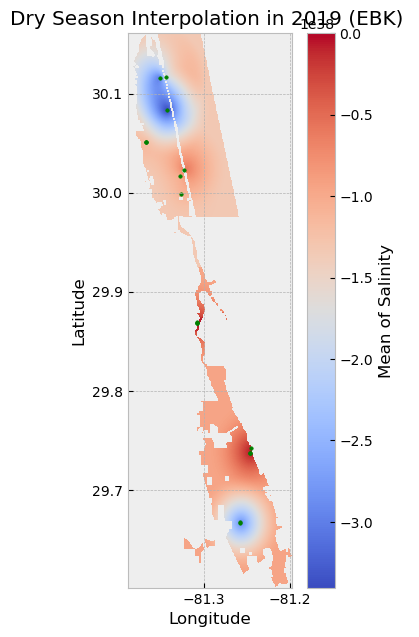

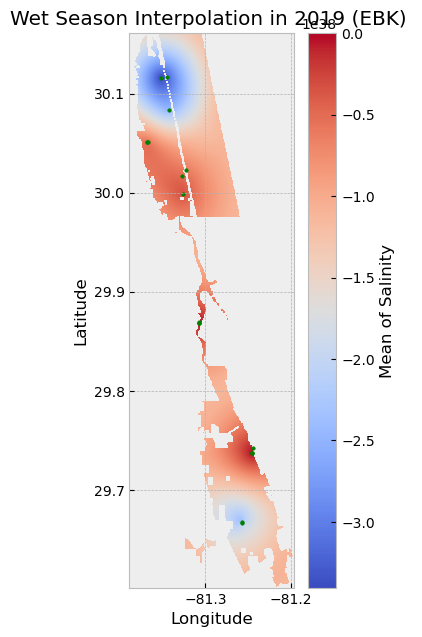

In [229]:
fig, ax5 , cbar1 = idw.show_map(
    input_raster='dryKriging.tif',
    colormap="coolwarm",
    image_size=1.5,
    return_figure=True)
ax5.set_title("Dry Season Interpolation in 2019 (EBK) ")
ax5.set_xlabel("Longitude")
ax5.set_ylabel("Latitude")
gdfDryShp.plot(ax = ax5, marker = 'o', color = 'green', markersize = 6)
cbar1.set_label("Mean of Salinity")

fig, ax6 , cbar1 = idw.show_map(
    input_raster='wetKriging.tif',
    colormap="coolwarm",
    image_size=1.5,
    return_figure=True)
ax6.set_title("Wet Season Interpolation in 2019 (EBK) ")
ax6.set_xlabel("Longitude")
ax6.set_ylabel("Latitude")
gdfDryShp.plot(ax = ax6, marker = 'o', color = 'green', markersize = 6)
cbar1.set_label("Mean of Salinity")

# IDW

In [111]:
gdfDryShp = gpd.read_file("gdfDry0116.shp")
gdfWetShp = gpd.read_file("gdfWet0116.shp")
bd        = gpd.read_file("ManagedArea/ORCP_Managed_Areas_Oct2021.shp")
bd        = bd[bd["LONG_NAME"] == listArea[0]]
bd.to_file('Bounds.shp', driver='ESRI Shapefile',crs="EPSG:4326")

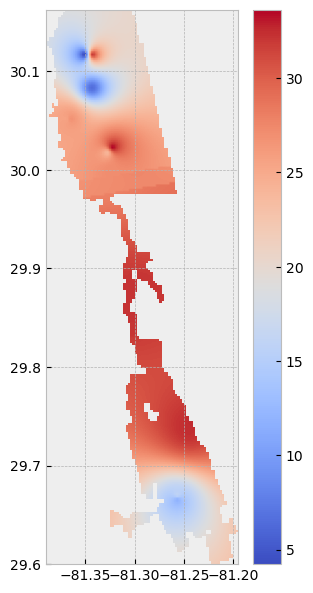

In [153]:
idw.idw_interpolation(
    input_point_shapefile="gdfDry0116.shp",
    extent_shapefile="Bounds.shp",
    column_name="ResultValu",
    power=2,
    search_radious=10,
    output_resolution=250
)

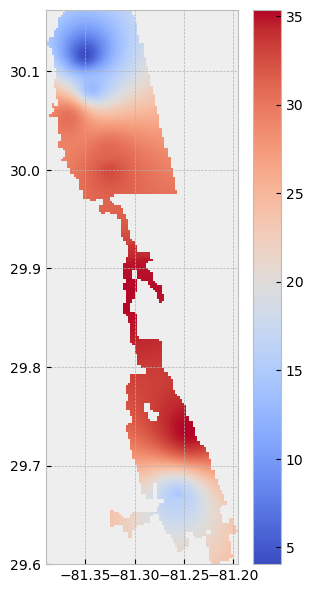

In [170]:
idw.idw_interpolation(
    input_point_shapefile="gdfWet0116.shp",
    extent_shapefile="Bounds.shp",
    column_name="ResultValu",
    power=2,
    search_radious=10,
    output_resolution=250
)

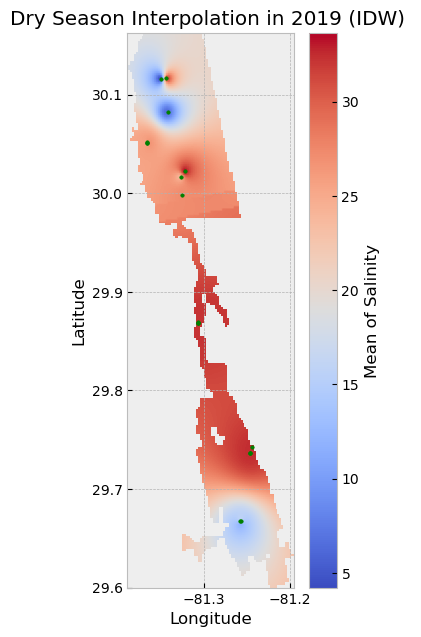

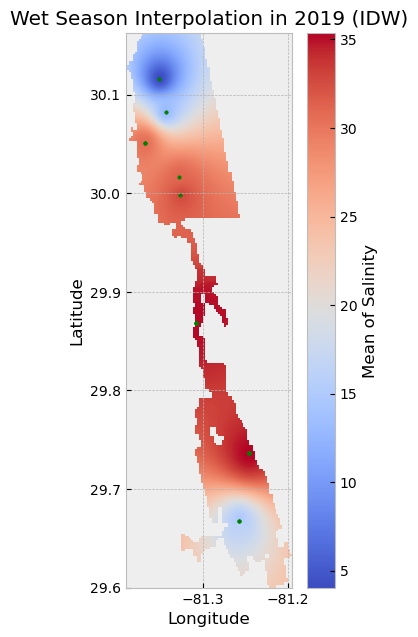

In [193]:
from pyidw import idw
from matplotlib import pyplot as plt

fig, ax1 , cbar1 = idw.show_map(
    input_raster="gdfDry0116_idw.tif",
    colormap="coolwarm",
    image_size=1.5,
    return_figure=True)
ax1.set_title("Dry Season Interpolation in 2019 (IDW) ")
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")
gdfDryShp.plot(ax = ax1, marker = 'o', color = 'green', markersize = 6)
cbar1.set_label("Mean of Salinity")


fig, ax2, cbar2 = idw.show_map(
    input_raster="gdfWet0116_idw.tif",
    colormap="coolwarm",
    image_size=1.5,
    return_figure=True)
ax2.set_title("Wet Season Interpolation in 2019 (IDW)")
ax2.set_xlabel("Longitude")
ax2.set_ylabel("Latitude")
gdfWetShp.plot(ax = ax2, marker = 'o', color = 'green', markersize = 6)
cbar2.set_label("Mean of Salinity")
plt.show()

# EBK

###   This part is finished by Notebook in ArcGIS Pro ###

In [ ]:
import arcpy

In [ ]:
with arcpy.EnvManager(extent="-81.388378263374 29.6015072696999 -81.1973302418821 30.1611311058652", mask="Guana"):
    arcpy.ga.EmpiricalBayesianKriging("gdfDry0116", 
                                      "ResultValu", 
                                      None, 
                                      "dryEBK.tif",
                                      0.000764192085967863,
                                      "NONE",
                                      100,
                                      1,
                                      100,
                                      "NBRTYPE=StandardCircular RADIUS=0.116565266510333 ANGLE=0 NBR_MAX=15 NBR_MIN=10 SECTOR_TYPE=ONE_SECTOR",
                                      "PREDICTION", 0.5, "EXCEED", None, "POWER")

In [ ]:
with arcpy.EnvManager(extent="-81.388378263374 29.6015072696999 -81.1973302418821 30.1611311058652", mask="Guana"):
    arcpy.ga.EmpiricalBayesianKriging("gdfWet0116", 
                                      "ResultValu", 
                                      None, 
                                      "wetEBK.tif",
                                      0.000764192085967863,
                                      "NONE",
                                      100,
                                      1,
                                      100,
                                      "NBRTYPE=StandardCircular RADIUS=0.116565266510333 ANGLE=0 NBR_MAX=15 NBR_MIN=10 SECTOR_TYPE=ONE_SECTOR",
                                      "PREDICTION", 0.5, "EXCEED", None, "POWER")

## Load Data

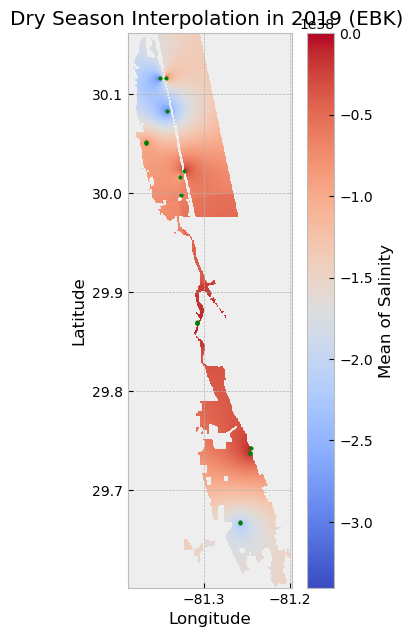

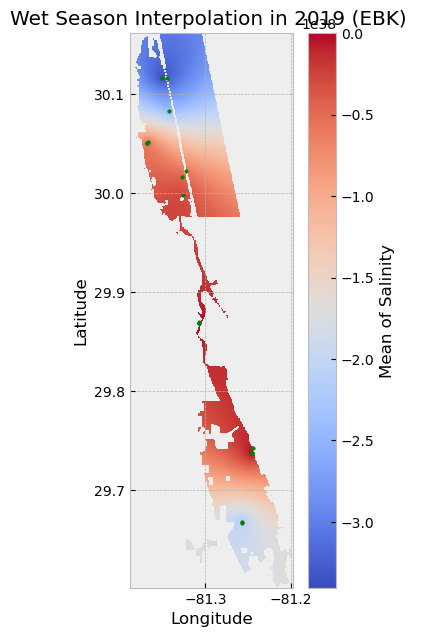

In [216]:
fig, ax3 , cbar1 = idw.show_map(
    input_raster='dryEBK.tif',
    colormap="coolwarm",
    image_size=1.5,
    return_figure=True)
ax3.set_title("Dry Season Interpolation in 2019 (EBK) ")
ax3.set_xlabel("Longitude")
ax3.set_ylabel("Latitude")
gdfDryShp.plot(ax = ax3, marker = 'o', color = 'green', markersize = 6)
cbar1.set_label("Mean of Salinity")

fig, ax4 , cbar1 = idw.show_map(
    input_raster='D:\wetEBK.tif',
    colormap="coolwarm",
    image_size=1.5,
    return_figure=True)
ax4.set_title("Wet Season Interpolation in 2019 (EBK) ")
ax4.set_xlabel("Longitude")
ax4.set_ylabel("Latitude")
gdfDryShp.plot(ax = ax4, marker = 'o', color = 'green', markersize = 6)
cbar1.set_label("Mean of Salinity")

In [ ]:
with arcpy.EnvManager(extent="-81.388378263374 29.6015072696999 -81.1973302418821 30.1611311058652", mask="Guana"):
    out_surface_raster = arcpy.sa.Kriging("gdfWet0116", "ResultValu", "Gaussian 0.000491 # # #", 0.000491060000000005, "VARIABLE 12", None); 
    out_surface_raster.save(r"D:\Water Quailty\wetKriging.tif")